In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
import cv2
import mediapipe as mp

#### Data

In [31]:
# Load the data from the pickle file
with open('data.pickle', 'rb') as f:
    data_dict = pickle.load(f)

# Extract features and labels
X = np.array(data_dict['data'])
y = np.array(data_dict['labels'])

# Encode the string labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Create class_names variable
class_names = label_encoder.classes_
class_names_size = len(class_names)
print(f"Class Names: {class_names}")
print(f"Len of Class Names: {class_names_size}")


Class Names: [0 1 2 3 4 5 6 7 8 9]
Len of Class Names: 10


#### Model

In [21]:
class HandLandmarkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HandLandmarkModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.ln1 = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 512)
        self.ln2 = nn.LayerNorm(512)
        self.fc3 = nn.Linear(512, 256)
        self.ln3 = nn.LayerNorm(256)
        self.fc4 = nn.Linear(256, 128)
        self.ln4 = nn.LayerNorm(128)
        self.fc5 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.ln3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.ln4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        return F.log_softmax(x, dim=1)
    


#### Training

TensorHandLandmarkTrainer initialized with device: cuda
CUDA device: NVIDIA GeForce GTX 1070
CUDA available: True
Current CUDA device: 0
PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce GTX 1070
Number of GPUs: 1
Training on device: cuda
Model is initially on device: cpu
Attempting to move model to cuda
After moving, model is on device: cuda:0
Forward pass successful with small batch
Model structure:
HandLandmarkModel(
  (fc1): Linear(in_features=42, out_features=256, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (ln3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (ln4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc5): Linear(in_features=128, out_f

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4961 | train_acc: 0.5891 | test_loss: 0.3327 | test_acc: 0.9868 | lr: 0.001000
Epoch: 2 | train_loss: 0.4098 | train_acc: 0.9664 | test_loss: 0.0703 | test_acc: 0.9906 | lr: 0.001000
Epoch: 3 | train_loss: 0.1508 | train_acc: 1.0085 | test_loss: 0.0370 | test_acc: 0.9944 | lr: 0.001000
Epoch: 4 | train_loss: 0.0920 | train_acc: 1.0109 | test_loss: 0.0258 | test_acc: 0.9944 | lr: 0.001000
Epoch: 5 | train_loss: 0.0711 | train_acc: 1.0109 | test_loss: 0.0229 | test_acc: 0.9962 | lr: 0.001000
Epoch: 6 | train_loss: 0.0601 | train_acc: 1.0123 | test_loss: 0.0171 | test_acc: 0.9962 | lr: 0.001000
Epoch: 7 | train_loss: 0.0372 | train_acc: 1.0170 | test_loss: 0.0106 | test_acc: 0.9944 | lr: 0.001000
Epoch: 8 | train_loss: 0.0473 | train_acc: 1.0132 | test_loss: 0.0140 | test_acc: 0.9962 | lr: 0.001000
Early stopping counter: 1 out of 20
Epoch: 9 | train_loss: 0.0485 | train_acc: 1.0151 | test_loss: 0.0147 | test_acc: 0.9962 | lr: 0.001000
Early stopping counter: 2 ou

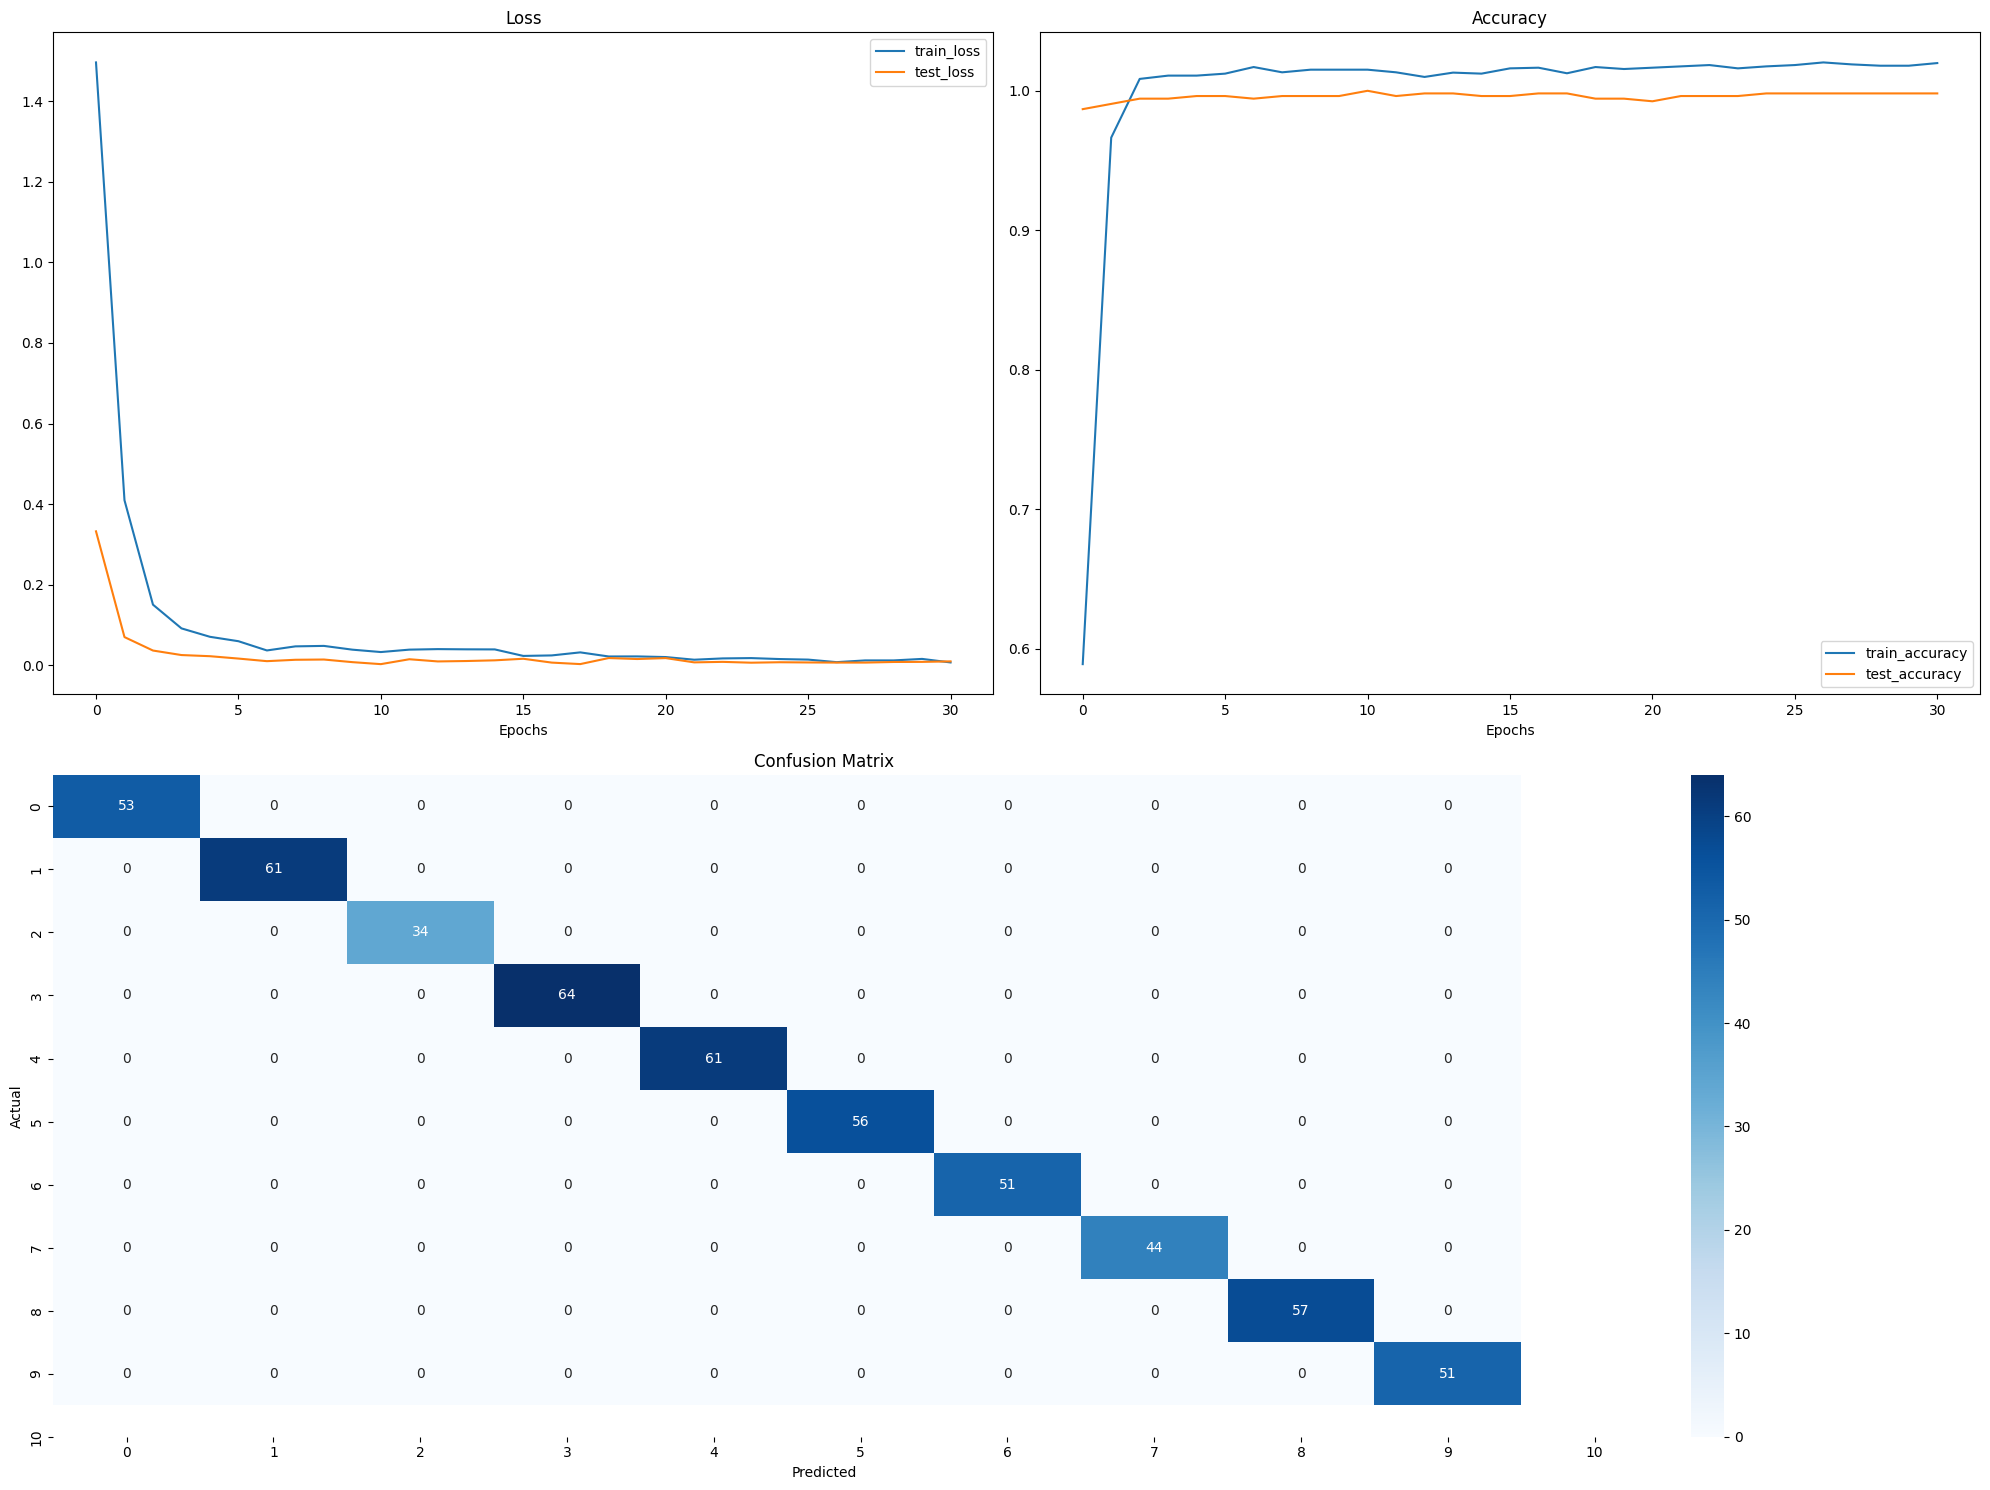

Model saved as models/numbers.pth


In [22]:
from modules.model_trainer import TensorHandLandmarkTrainer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from modules.model_performance import TensorHandLandmarkVisualizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure your data is in the correct shape
X_train = X_train.reshape(-1, 42)  # Adjust 42 to your input size if different
X_test = X_test.reshape(-1, 42)

# Model initialization
model = HandLandmarkModel(input_size=42, num_classes=class_names_size)

# Training parameters
batch_size = 45
learning_rate = 0.001
NUM_EPOCHS = 200

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.NLLLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Training
trainer = TensorHandLandmarkTrainer()
TRAINED_MODEL, RESULTS = trainer.train(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test, 
    y_test=y_test, 
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=NUM_EPOCHS,
    scheduler=scheduler,
    patience=20,
    batch_size=batch_size 
)

# Plot the results
num_classes = 11
visualizer = TensorHandLandmarkVisualizer(RESULTS)
y_true, y_pred = visualizer.get_preds(model=TRAINED_MODEL, X=X_test, y=y_test, device=device)
visualizer.plot_all(y_true=y_true, y_pred=y_pred, classes=list(range(num_classes)), save_path="model_performance/plot.jpg")

model_name = "models/numbers.pth"

# Save the model
torch.save(model.state_dict(), model_name)
print(f"Model saved as {model_name}")

#### Report

In [25]:
from modules.model_saver import ModelSaver

model = HandLandmarkModel(input_size=42, num_classes=class_names_size)  # Adjust input_size and num_classes as needed

model_name = "numbers.pth"
saver = ModelSaver(target_dir="models")
loaded_model = saver.load_model(model=model, model_name=model_name)

[INFO] Loading model from: models\numbers.pth


In [35]:
from modules.model_eval import HandLandMarksEvaluator

class_names = [f"Class {i}" for i in range(len(class_names))]

evaluator = HandLandMarksEvaluator(loaded_model)
results = evaluator.evaluate_and_report(X_test, y_test, class_names=class_names)

print(f"Accuracy: {results['accuracy']:.4f}")
print("Classification Report:")
print(results['classification_report'])

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        53
     Class 1       1.00      1.00      1.00        61
     Class 2       1.00      1.00      1.00        34
     Class 3       1.00      1.00      1.00        64
     Class 4       1.00      1.00      1.00        61
     Class 5       1.00      1.00      1.00        56
     Class 6       1.00      1.00      1.00        51
     Class 7       1.00      1.00      1.00        44
     Class 8       1.00      1.00      1.00        57
     Class 9       1.00      1.00      1.00        51

    accuracy                           1.00       532
   macro avg       1.00      1.00      1.00       532
weighted avg       1.00      1.00      1.00       532



#### Inference

In [39]:
# Load the trained model
model = HandLandmarkModel(input_size=42, num_classes=class_names_size) 
model.load_state_dict(torch.load('models/numbers.pth'))
model.eval()

cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

labels_dict = {0: '0', 
               1: '1', 
               2: '2',
               3: '3', 
               4: '4', 
               5: '5', 
               6: '6', 
               7: '7',
               8: '8',
               9: '9',}

while True:
    data_aux = []
    x_ = []
    y_ = []

    ret, frame = cap.read()
    H, W, _ = frame.shape
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]

        mp_drawing.draw_landmarks(
            frame,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        for i in range(len(hand_landmarks.landmark)):
            x = hand_landmarks.landmark[i].x
            y = hand_landmarks.landmark[i].y
            x_.append(x)
            y_.append(y)

        for i in range(len(hand_landmarks.landmark)):
            x = hand_landmarks.landmark[i].x
            y = hand_landmarks.landmark[i].y
            data_aux.append(x - min(x_))
            data_aux.append(y - min(y_))

        x1 = int(min(x_) * W) - 10
        y1 = int(min(y_) * H) - 10
        x2 = int(max(x_) * W) - 10
        y2 = int(max(y_) * H) - 10

        # Normalize the input data
        data_aux = np.array(data_aux)
        data_aux = (data_aux - np.mean(data_aux)) / np.std(data_aux)

        # Convert to PyTorch tensor
        input_tensor = torch.FloatTensor(data_aux).unsqueeze(0)  # Add batch dimension

        # Make prediction
        with torch.no_grad():
            output = model(input_tensor)
            prediction = torch.argmax(output, dim=1).item()

        predicted_character = labels_dict[prediction]

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 0), 4)
        cv2.putText(frame, predicted_character, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255,255,255), 3, cv2.LINE_AA)

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#### Convert To Android

In [40]:
example_input = torch.rand(1, 42)
scripted_model = torch.jit.script(model)
# Save the TorchScript model
scripted_model.save("numbers_android.pt")